In [19]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from tensorflow.keras.utils import timeseries_dataset_from_array
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Dense, Dropout, LSTM, Bidirectional
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

In [20]:
df = pd.read_csv("jena_climate_2009_2016.csv")

In [21]:
temperature = df["T (degC)"].values

In [22]:
raw_data = df.loc[:, "p (mbar)":"wd (deg)"].values

**Data split**

In [23]:
num_train_samples = int(0.5 * len(raw_data))
num_val_samples = int(0.25 * len(raw_data))
num_test_samples = len(raw_data) - num_train_samples - num_val_samples

**Normalizing the data**

In [24]:
mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean

std = raw_data[:num_train_samples].std(axis=0)
raw_data /= std

**Instantiating datasets for training, validation, and testing**

In [25]:
sampling_rate = 6
sequence_length = 120
delay = sampling_rate * (sequence_length + 24 - 1)
batch_size = 256

In [26]:
train_dataset = timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples)

val_dataset = timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples)

test_dataset = timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples)

### Using bidirectional RNNs

**Training and evaluating a bidirectional LSTM**

In [27]:
inputs = Input(shape=(sequence_length, raw_data.shape[-1]))
x = Bidirectional(LSTM(16))(inputs)
outputs = Dense(1)(x)
model = Model(inputs, outputs)

In [28]:
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset, epochs=10, validation_data=val_dataset)

Epoch 1/10
819/819 [==============================] - 27s 27ms/step - loss: 29.2266 - mae: 3.8696 - val_loss: 10.8878 - val_mae: 2.5583
Epoch 2/10
819/819 [==============================] - 23s 28ms/step - loss: 9.6650 - mae: 2.4320 - val_loss: 9.8284 - val_mae: 2.4169
Epoch 3/10
819/819 [==============================] - 22s 27ms/step - loss: 8.6297 - mae: 2.2900 - val_loss: 10.1520 - val_mae: 2.4525
Epoch 4/10
819/819 [==============================] - 22s 27ms/step - loss: 7.9485 - mae: 2.1972 - val_loss: 9.8788 - val_mae: 2.4270
Epoch 5/10
819/819 [==============================] - 22s 27ms/step - loss: 7.4729 - mae: 2.1294 - val_loss: 9.9538 - val_mae: 2.4490
Epoch 6/10
819/819 [==============================] - 22s 27ms/step - loss: 7.1059 - mae: 2.0763 - val_loss: 10.6955 - val_mae: 2.5286
Epoch 7/10
819/819 [==============================] - 22s 27ms/step - loss: 6.8024 - mae: 2.0303 - val_loss: 11.0538 - val_mae: 2.5625
Epoch 8/10
819/819 [==============================] - 22s

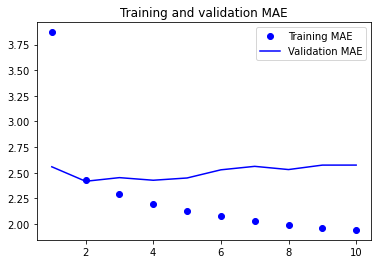

In [29]:
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()